In [17]:
import numpy as np
import pandas as pd

In [7]:
import pandas_datareader as pdr

In [8]:
key=''#put your API key here

In [11]:
df = pdr.get_data_tiingo('AAPL', api_key=key)
df.to_csv('AAPL.csv')
df=pd.read_csv('AAPL.csv')


In [13]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-07-25 00:00:00+00:00,152.74,153.84,151.80,151.80,18612649,36.141886,36.402172,35.919460,35.919460,74450596,0.0,1.0
1,AAPL,2017-07-26 00:00:00+00:00,153.46,153.93,153.06,153.35,15172136,36.312255,36.423468,36.217605,36.286226,60688544,0.0,1.0
2,AAPL,2017-07-27 00:00:00+00:00,150.56,153.99,147.30,153.75,32175875,35.626046,36.437665,34.854653,36.380876,128703500,0.0,1.0
3,AAPL,2017-07-28 00:00:00+00:00,149.50,150.23,149.19,149.89,16832947,35.375225,35.547961,35.301872,35.467509,67331788,0.0,1.0
4,AAPL,2017-07-31 00:00:00+00:00,148.73,150.33,148.13,149.90,19422655,35.193025,35.571623,35.051051,35.469875,77690620,0.0,1.0


In [14]:
df1=df.reset_index()['close']

In [15]:
df1

0       152.74
1       153.46
2       150.56
3       149.50
4       148.73
         ...  
1253    147.07
1254    151.00
1255    153.04
1256    155.35
1257    154.09
Name: close, Length: 1258, dtype: float64

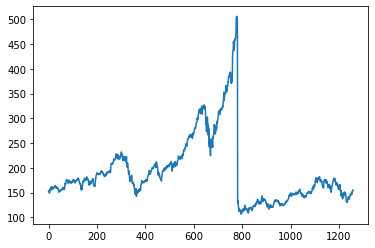

In [16]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [19]:
df1

array([[0.11496556],
       [0.11676894],
       [0.10950532],
       ...,
       [0.11571697],
       [0.12150282],
       [0.1183469 ]])

In [28]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [29]:
training_size,test_size

(817, 441)

In [32]:
def create_dataset(dataset, time_step=1):
# convert an array of values into a dataset matrix
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [36]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [37]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [38]:
print(X_test.shape),print(y_test.shape)

(340, 100)
(340,)


(None, None)

In [40]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [41]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [42]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 6s 201ms/step - loss: 0.0533 - val_loss: 0.0114
Epoch 2/100
12/12 [==============================] - 1s 121ms/step - loss: 0.0144 - val_loss: 0.0087
Epoch 3/100
12/12 [==============================] - 1s 120ms/step - loss: 0.0116 - val_loss: 4.0488e-04
Epoch 4/100
12/12 [==============================] - 1s 122ms/step - loss: 0.0113 - val_loss: 0.0036
Epoch 5/100
12/12 [==============================] - 2s 131ms/step - loss: 0.0102 - val_loss: 0.0038
Epoch 6/100
12/12 [==============================] - 1s 121ms/step - loss: 0.0087 - val_loss: 0.0010
Epoch 7/100
12/12 [==============================] - 1s 121ms/step - loss: 0.0071 - val_loss: 2.3988e-04
Epoch 8/100
12/12 [==============================] - 1s 111ms/step - loss: 0.0064 - val_loss: 9.3726e-04
Epoch 9/100
12/12 [==============================] - 1s 111ms/step - loss: 0.0058 - val_loss: 6.9343e-04
Epoch 10/100
12/12 [==============================] - 1s 115ms/step - loss:

12/12 [==============================] - 1s 120ms/step - loss: 0.0014 - val_loss: 2.5440e-04
Epoch 79/100
12/12 [==============================] - 1s 127ms/step - loss: 0.0019 - val_loss: 1.7625e-04
Epoch 80/100
12/12 [==============================] - 1s 122ms/step - loss: 0.0017 - val_loss: 5.0873e-04
Epoch 81/100
12/12 [==============================] - 1s 120ms/step - loss: 0.0014 - val_loss: 3.5419e-04
Epoch 82/100
12/12 [==============================] - 2s 126ms/step - loss: 0.0013 - val_loss: 1.9320e-04
Epoch 83/100
12/12 [==============================] - 1s 121ms/step - loss: 0.0023 - val_loss: 3.6101e-04
Epoch 84/100
12/12 [==============================] - 1s 118ms/step - loss: 0.0024 - val_loss: 1.8533e-04
Epoch 85/100
12/12 [==============================] - 1s 121ms/step - loss: 0.0022 - val_loss: 2.8472e-04
Epoch 86/100
12/12 [==============================] - 1s 120ms/step - loss: 0.0018 - val_loss: 2.4289e-04
Epoch 87/100
12/12 [==============================] - 1s 12

In [46]:
import tensorflow as tf

In [47]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [48]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [51]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

234.34274182343123

In [50]:
math.sqrt(mean_squared_error(ytest,test_predict))

152.76686093981672

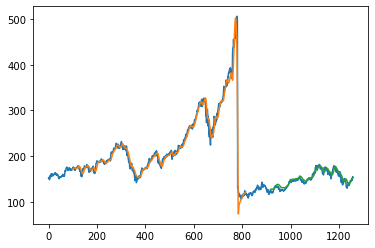

In [53]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [54]:
len(test_data)

441

In [57]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
x_input.shape

(1, 100)

In [58]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [61]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.1208516  0.13212273 0.13470257 0.14311835 0.14662492 0.15524108
 0.1587226  0.16839073 0.17001879 0.17222292 0.1806387  0.17765811
 0.16974327 0.16899186 0.17933626 0.17087038 0.16278021 0.16355667
 0.15842204 0.14755166 0.15233563 0.1591985  0.1463995  0.14584847
 0.15168441 0.15125861 0.14922981 0.13763306 0.14036318 0.12513463
 0.12455855 0.14226675 0.12726362 0.12804008 0.13184721 0.14822793
 0.12505949 0.12633688 0.11326237 0.11939887 0.09933626 0.08946775
 0.10086412 0.09693175 0.10619912 0.08510958 0.07641828 0.07701941
 0.09084534 0.08395742 0.08435817 0.09252348 0.107201   0.10519724
 0.10487163 0.11113338 0.096531   0.09843456 0.10487163 0.10299311
 0.08966813 0.07586725 0.0627176  0.06492173 0.07160927 0.05815905
 0.06191609 0.07271133 0.07140889 0.0787226  0.08721353 0.08721353
 0.07664371 0.08112711 0.07484033 0.0803757  0.08696306 0.09036944
 0.09896055 0.10068879 0.0952536  0.09773325 0.09680651 0.10427051
 0.10852849 0.10076393 0.11060739 0.11571697 0.121

In [62]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

In [63]:
len(df1)

1258

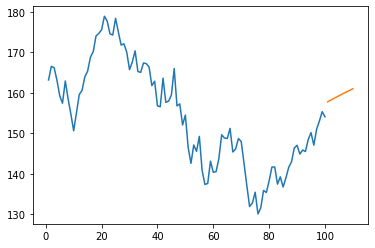

In [65]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-time_step:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

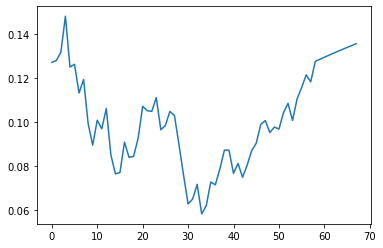

In [66]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])